In [1]:
import pysm3
import pysm3.utils as utils
import pysm3.units as u
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
from qubic import NamasterLib as nam
from scipy.optimize import curve_fit
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

# %matplotlib ipympl

def give_cls_cmb(ell=None, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    if ell is not None:
        return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])
    else:
        return power_spectrum

def dl_dust(x,Ad,betad):
    return Ad * (x/200)**betad

def dl_dust_const(x,Ad):
    return Ad * np.ones(len(x))

base_dir = '/home/nahue-ofi/'
# base_dir = '/home/nahue/'

In [2]:
## maps features

# ## convolution operator
# C = HealpixConvolutionGaussianOperator(fwhm=self.joint_in.qubic.allfwhm[-1], lmax=2*self.params['MapMaking']['qubic']['nside'])
scanning = np.load('coverage_and_center.npy',allow_pickle=True).item()

coverage_in = scanning['coverage']
center = [scanning['center'][0],scanning['center'][1]]

del(scanning)

nside = 256

# nside_coverage = hp.pixelfunc.get_nside(coverage)
# print(nside_coverage)
# print(nside)
# seenpix_coverage = coverage / coverage.max() > covcut
# seenpix = hp.pixelfunc.ud_grade(seenpix_coverage, nside)

covcut = 0.1
coverage = hp.pixelfunc.ud_grade(coverage_in, nside)
seenpix = coverage / coverage.max() > covcut
mask = np.zeros(len(seenpix))
mask[seenpix] = 1

# initializing Namaster for computing the spectra just for the QUBIC patch

dl = 30
lmin = 26
lmax = 2 * nside
aposize = 10

namaster = nam.Namaster(seenpix, lmin=lmin, lmax=lmax, delta_ell=dl, aposize=aposize)

ell_nam, _ = namaster.get_binning(nside)
_f_nam = ell_nam * (ell_nam + 1) / (2 * np.pi)

beam_correction = None #np.rad2deg(0.00415369)
pixwin_correction = False #True

In [3]:
## cmb map from planck Cls
r = 0
Alens = 1
cmb_seed = None
cls_cmb = give_cls_cmb(r=r, Alens=Alens)
np.random.seed(cmb_seed)
cmb = hp.synfast(cls_cmb, nside, new=True).T

# print(cmb.shape)
# hp.mollview(cmb[:,0])
# # hp.mollview(cmb[:,2])

_, dls_cmb_qp, _ = namaster.get_spectra(cmb.T, beam_correction=beam_correction, pixwin_correction=pixwin_correction, verbose=False)

cls_cmb_ana = hp.anafast(cmb.T,lmax=2*nside)
print(cls_cmb_ana.shape)

(6, 513)


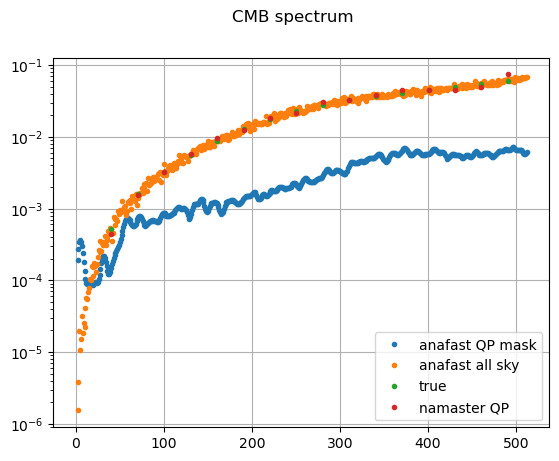

In [4]:
cmb_masked = np.zeros(np.shape(cmb))
for i in range(3):
    cmb_masked[:,i] = cmb[:,i]*mask

# print(cmb.shape)
# print(cmb_masked.shape)
# print(mask.shape)
cls_cmb_ana_masked = hp.anafast(cmb_masked.T,lmax=2*nside)
# print(cls_cmb_ana_masked.shape)

ell_syn = np.linspace(1,len(cls_cmb_ana[2]),len(cls_cmb_ana[2]))

_f_syn = ell_syn * (ell_syn + 1) / (2 * np.pi)

plt.figure()
plt.suptitle('CMB spectrum')
plt.plot(_f_syn*cls_cmb_ana_masked[2,:],'.',label='anafast QP mask')
plt.plot(_f_syn*cls_cmb_ana[2,:],'.',label='anafast all sky')
plt.plot(ell_nam,_f_nam*give_cls_cmb(ell_nam,r=r,Alens=Alens),'.',label='true')
plt.plot(ell_nam,dls_cmb_qp[:,2],'.',label='namaster QP')
plt.legend()
plt.grid()
plt.yscale('log')

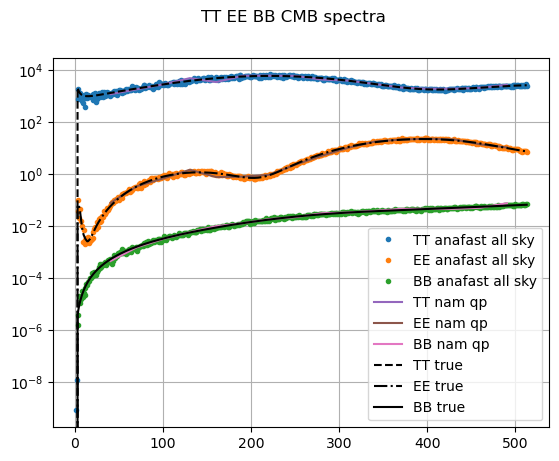

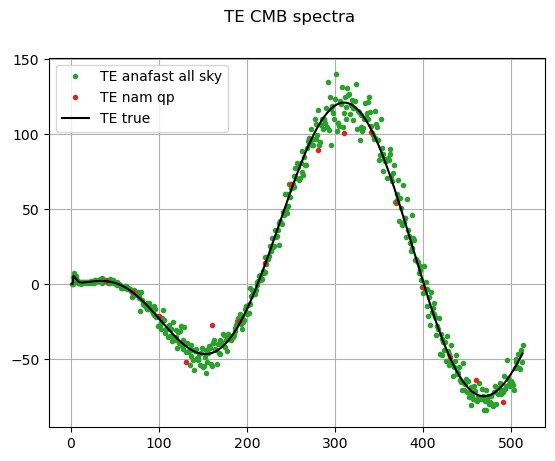

In [5]:
plt.figure()
plt.suptitle('TT EE BB CMB spectra')
plt.plot(ell_syn,_f_syn*cls_cmb_ana[0,:],'.',color='C0',label='TT anafast all sky')
plt.plot(ell_syn,_f_syn*cls_cmb_ana[1,:],'.',color='C1',label='EE anafast all sky')
plt.plot(ell_syn,_f_syn*cls_cmb_ana[2,:],'.',color='C2',label='BB anafast all sky')
plt.plot(ell_nam,dls_cmb_qp[:,0],'-',color='C4',label='TT nam qp')
plt.plot(ell_nam,dls_cmb_qp[:,1],'-',color='C5',label='EE nam qp')
plt.plot(ell_nam,dls_cmb_qp[:,2],'-',color='C6',label='BB nam qp')
plt.plot(ell_syn,_f_syn*cls_cmb[0,:2*nside+1],'--',color='k',label='TT true')
plt.plot(ell_syn,_f_syn*cls_cmb[1,:2*nside+1],'-.',color='k',label='EE true')
plt.plot(ell_syn,_f_syn*cls_cmb[2,:2*nside+1],'-',color='k',label='BB true')


plt.grid()
plt.legend()
plt.yscale('log')

plt.figure()
plt.suptitle('TE CMB spectra')
plt.plot(ell_syn,_f_syn*cls_cmb_ana[3,:],'.',color='C2',label='TE anafast all sky')
plt.plot(ell_nam,dls_cmb_qp[:,3],'.',color='C3',label='TE nam qp')
plt.plot(ell_syn,_f_syn*cls_cmb[3,:2*nside+1],'-',color='k',label='TE true')
# plt.plot(ell_syn,dl_dust_const(ell_syn,Ad_TEfit_c),color='C3')
# plt.plot(ell_syn[30:],dl_dust(ell_syn[30:],Ad_TEfit,betad_TEfit),color='C3')

plt.grid()
plt.legend()

In [6]:
## since for CMB the Namaster QP and the anafast entire sky spectra are the same I can convert from cls to maps and from maps to cls consequtively
## for dust is different because the Namaster QP is not the same as the anafast entire sky not because of an inacurracy but due to the fact
## that dust is not a pixel-independent random realization of some distribution. In all case the distribution depends on each pixel even
## within the qubic patch.

(786432, 3)


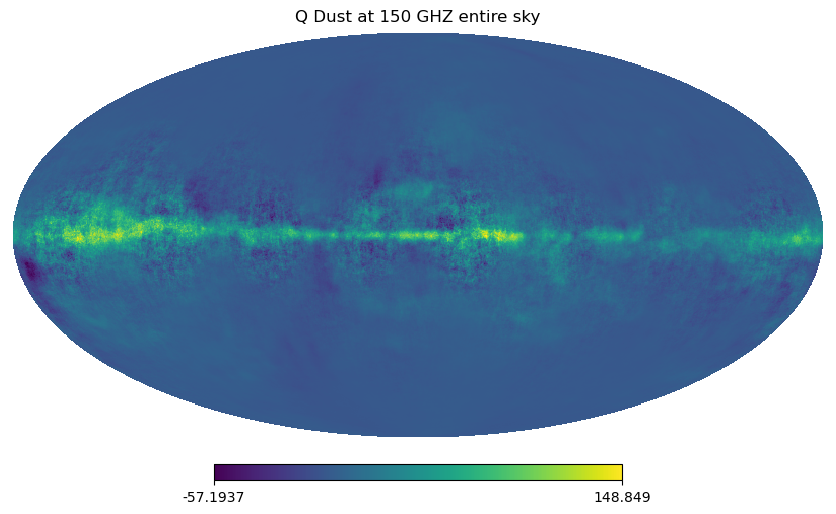

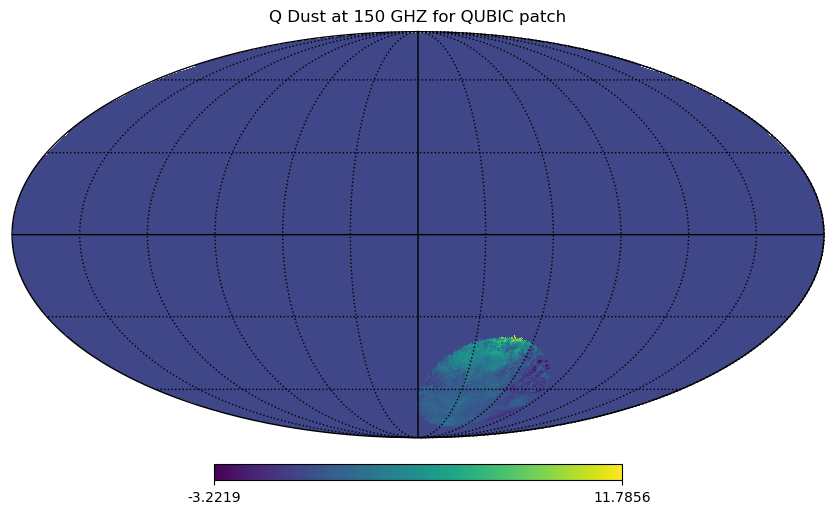

In [7]:
## dust map at freq_ref
freq_ref = 150
dust_model = 'd0'
sky=pysm3.Sky(nside=nside, preset_strings=[dust_model], output_unit="uK_CMB")
map_dust_input = np.array(sky.get_emission(freq_ref * u.GHz, None).T * \
                                  utils.bandpass_unit_conversion(freq_ref * u.GHz, None, u.uK_CMB))

print(map_dust_input.shape)
hp.mollview(map_dust_input[:,1],title='Q Dust at 150 GHZ entire sky')#,norm='hist')#,remove_mono=True,remove_dip=True
hp.mollview(mask*map_dust_input[:,1],title='Q Dust at 150 GHZ for QUBIC patch')
hp.graticule()

In [8]:
cls_dust_input_anafast = hp.anafast(map_dust_input.T,lmax=2*nside)

_, dls_dust_input_qp, _ = namaster.get_spectra(map_dust_input.T, beam_correction=beam_correction, pixwin_correction=pixwin_correction, verbose=False)

print(dls_dust_input_qp.shape)

(16, 4)


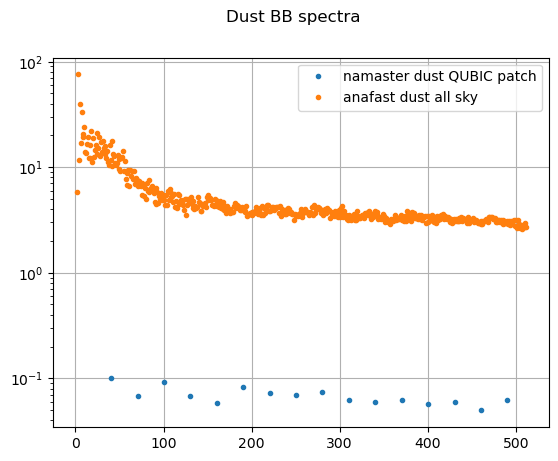

In [9]:
plt.figure()
plt.suptitle('Dust BB spectra')
plt.plot(ell_nam,dls_dust_input_qp[:,2],'.',label='namaster dust QUBIC patch')
# plt.plot(ell_nam,_f_nam*give_cls_cmb(ell_nam,r=r,Alens=Alens),'.',label='True CMB')
plt.plot(_f_syn*cls_dust_input_anafast[2,:],'.',label='anafast dust all sky')
plt.grid()
plt.legend()
plt.yscale('log')

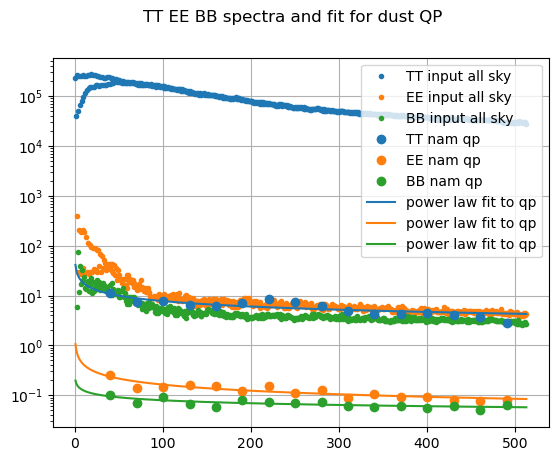

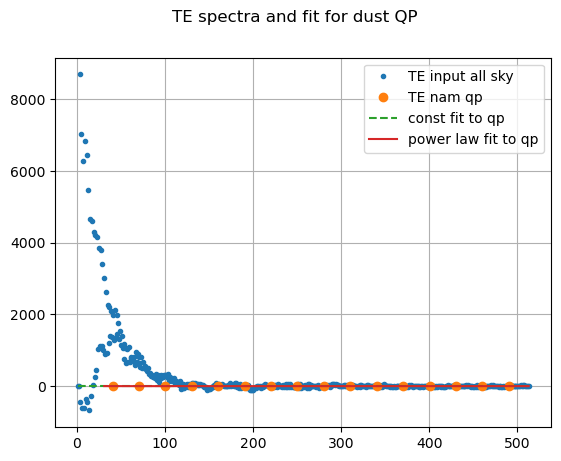

In [10]:
## fitting namaster spectra to power laws or const.

popt, pcov = curve_fit(dl_dust, ell_nam, dls_dust_input_qp[:,0])
Ad_TTfit = popt[0]
betad_TTfit = popt[1]
popt, pcov = curve_fit(dl_dust, ell_nam, dls_dust_input_qp[:,1])
Ad_EEfit = popt[0]
betad_EEfit = popt[1]
popt, pcov = curve_fit(dl_dust, ell_nam, dls_dust_input_qp[:,2])
Ad_BBfit = popt[0]
betad_BBfit = popt[1]
popt, pcov = curve_fit(dl_dust, ell_nam, dls_dust_input_qp[:,3])#,p0=popt)
Ad_TEfit = popt[0]
betad_TEfit = popt[1]
popt, pcov = curve_fit(dl_dust_const, ell_nam, dls_dust_input_qp[:,3])#,p0=popt)
Ad_TEfit_c = popt[0]

plt.figure()
plt.suptitle('TT EE BB spectra and fit for dust QP')
plt.plot(ell_syn,_f_syn*cls_dust_input_anafast[0,:],'.',label='TT input all sky')
plt.plot(ell_syn,_f_syn*cls_dust_input_anafast[1,:],'.',label='EE input all sky')
plt.plot(ell_syn,_f_syn*cls_dust_input_anafast[2,:],'.',label='BB input all sky')
plt.plot(ell_nam,dls_dust_input_qp[:,0],'o',color='C0',label='TT nam qp')
plt.plot(ell_nam,dls_dust_input_qp[:,1],'o',color='C1',label='EE nam qp')
plt.plot(ell_nam,dls_dust_input_qp[:,2],'o',color='C2',label='BB nam qp')
plt.plot(ell_syn,dl_dust(ell_syn,Ad_TTfit,betad_TTfit),color='C0',label='power law fit to qp')
plt.plot(ell_syn,dl_dust(ell_syn,Ad_EEfit,betad_EEfit),color='C1',label='power law fit to qp')
plt.plot(ell_syn,dl_dust(ell_syn,Ad_BBfit,betad_BBfit),color='C2',label='power law fit to qp')
plt.grid()
plt.legend()
plt.yscale('log')

plt.figure()
plt.suptitle('TE spectra and fit for dust QP')
plt.plot(ell_syn,_f_syn*cls_dust_input_anafast[3,:],'.',label='TE input all sky')
plt.plot(ell_nam,dls_dust_input_qp[:,3],'o',label='TE nam qp')
plt.plot(ell_syn,dl_dust_const(ell_syn,Ad_TEfit_c),'--',label='const fit to qp')
plt.plot(ell_syn[30:],dl_dust(ell_syn[30:],Ad_TEfit,betad_TEfit),'-',label='power law fit to qp')


plt.grid()
plt.legend()

In [11]:
cls_dust_fit = np.array([dl_dust(ell_syn,Ad_TTfit,betad_TTfit), dl_dust(ell_syn,Ad_EEfit,betad_EEfit),dl_dust(ell_syn,Ad_BBfit,betad_BBfit),dl_dust_const(ell_syn,Ad_TEfit_c)])/_f_syn
print(cls_dust_fit.shape)

(4, 513)


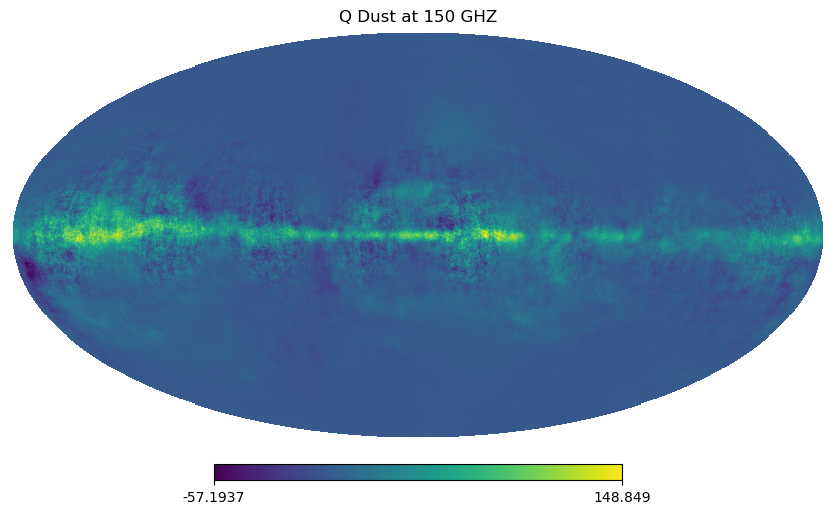

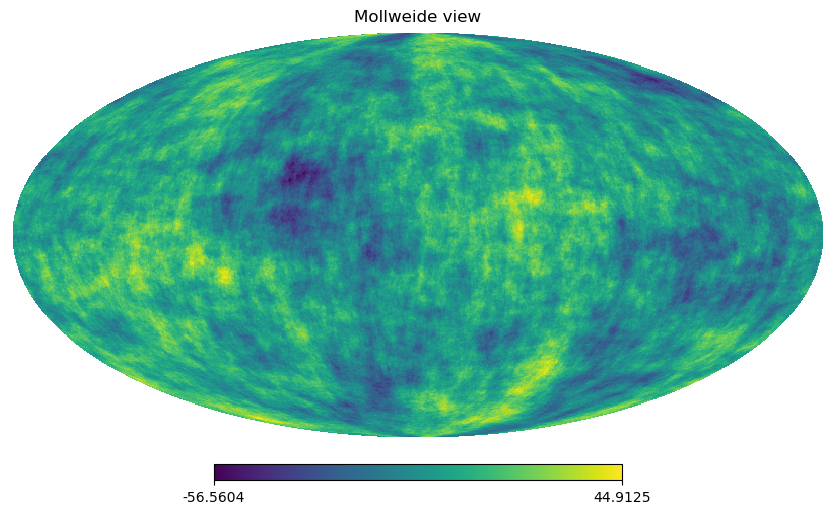

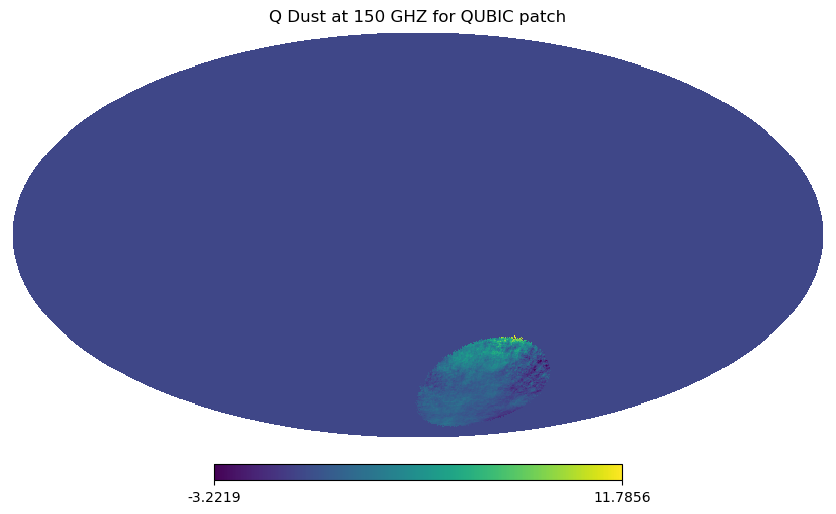

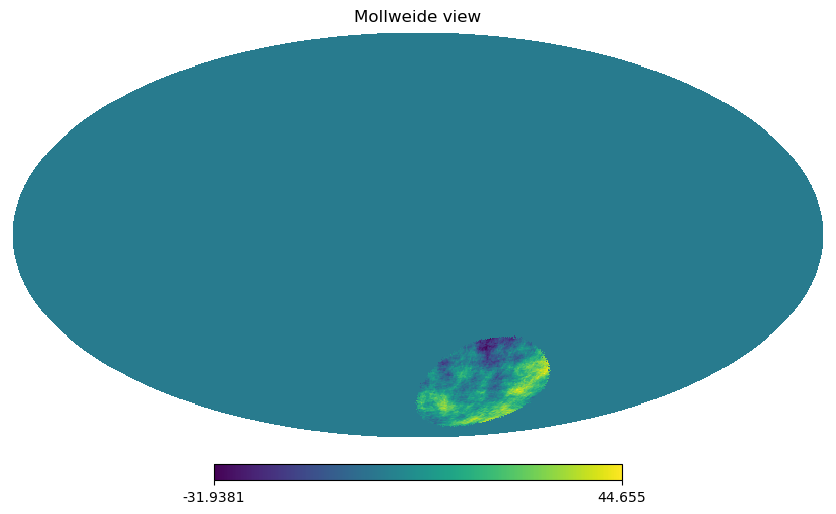

In [12]:
map_dust_syn_anafast = hp.synfast(cls_dust_input_anafast, nside, new=True).T
map_dust_syn_qp_fit = hp.synfast(cls_dust_fit, nside, new=True).T
# map_dust_syn_rescaled = hp.synfast(cls_dust_rescaled.T, nside, new=True).T

# print(dust_syn_ana.shape)
# hp.mollview(dust_2[:,1])
hp.mollview(map_dust_input[:,1],title='Q Dust at 150 GHZ')
hp.mollview(map_dust_syn_anafast[:,1])
hp.mollview(mask*map_dust_input[:,1],title='Q Dust at 150 GHZ for QUBIC patch')
hp.mollview(map_dust_syn_anafast[:,1]*mask)

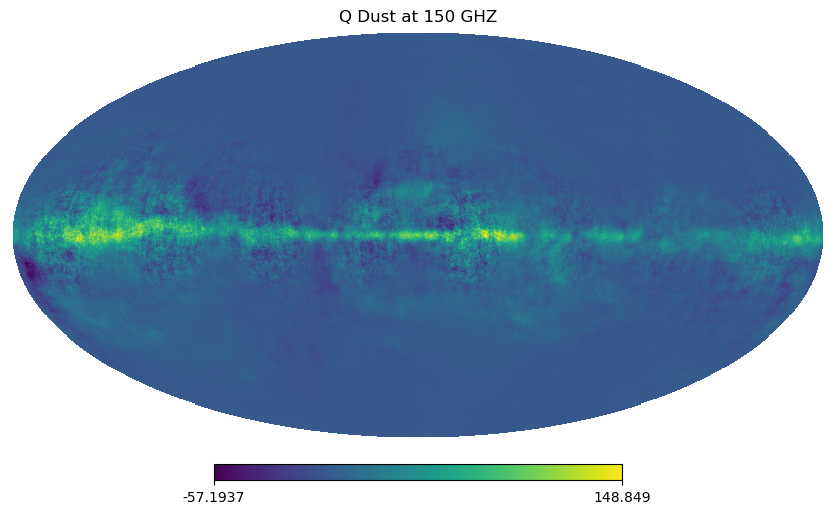

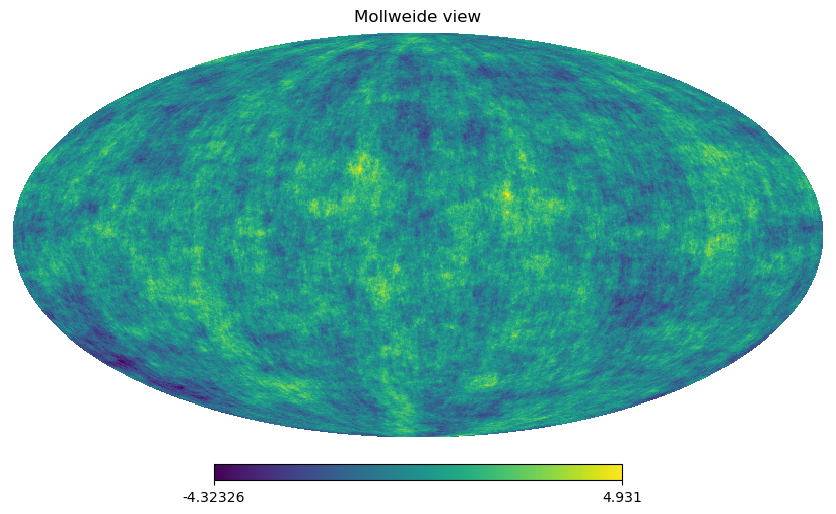

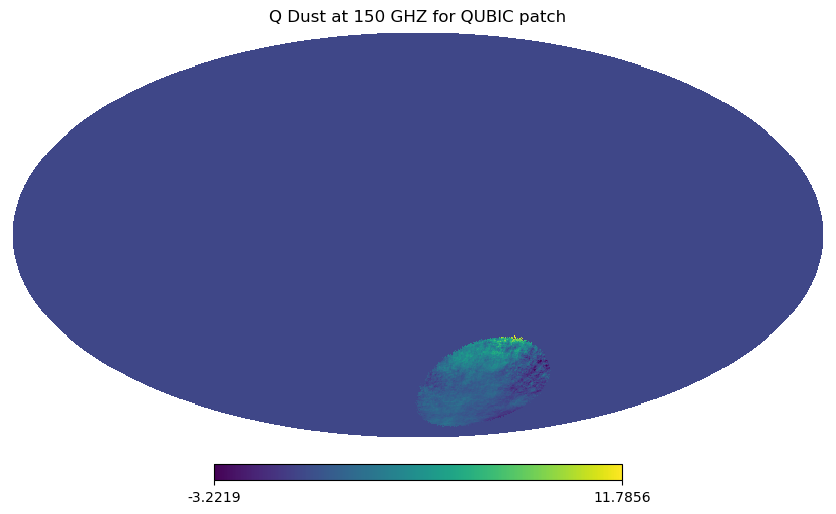

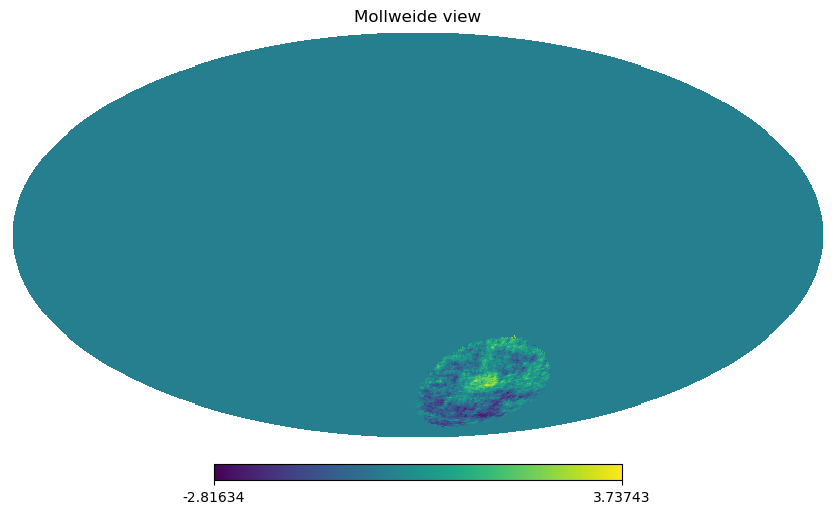

In [13]:
hp.mollview(map_dust_input[:,1],title='Q Dust at 150 GHZ')
hp.mollview(map_dust_syn_qp_fit[:,1])
hp.mollview(mask*map_dust_input[:,1],title='Q Dust at 150 GHZ for QUBIC patch')
hp.mollview(map_dust_syn_qp_fit[:,1]*mask)

In [14]:
_, dls_from_map_dust_syn_anafast_with_namaster, _ = namaster.get_spectra(map_dust_syn_anafast.T, beam_correction=beam_correction, pixwin_correction=pixwin_correction, verbose=False)

cls_from_map_dust_syn_anafast_with_anafast = hp.anafast(map_dust_syn_anafast.T,lmax=2*nside)

_, dls_from_map_dust_syn_qp_fit_with_namaster, _ = namaster.get_spectra(map_dust_syn_qp_fit.T, beam_correction=beam_correction, pixwin_correction=pixwin_correction, verbose=False)

cls_from_map_dust_syn_qp_fit_with_anafast = hp.anafast(map_dust_syn_qp_fit.T,lmax=2*nside)

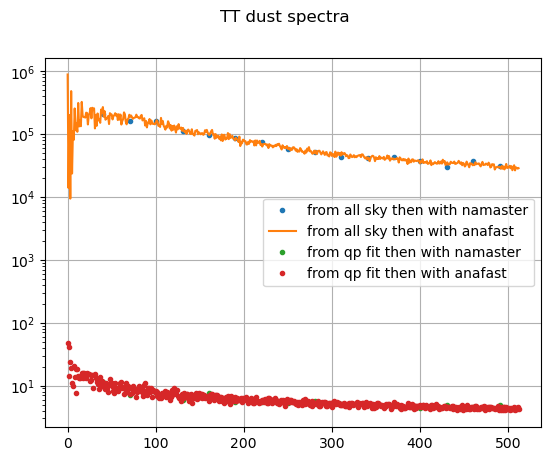

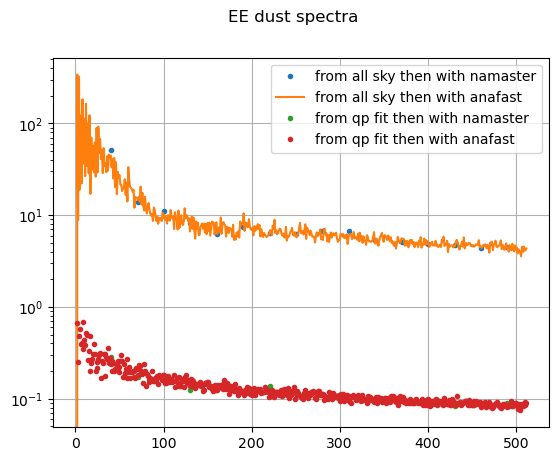

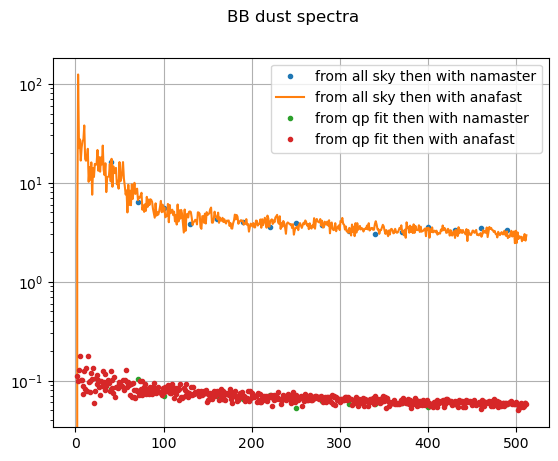

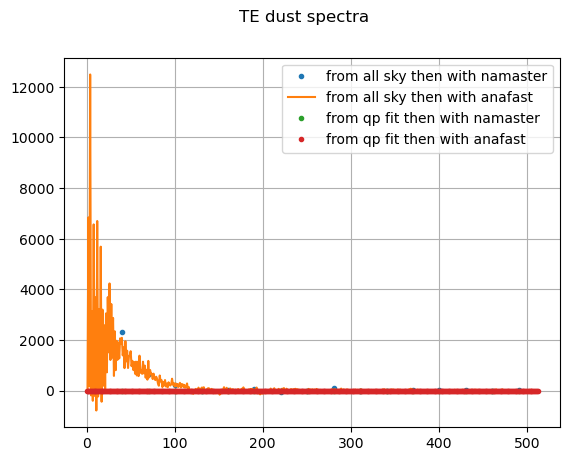

In [15]:
plt.figure()
plt.suptitle('TT dust spectra')
plt.plot(ell_nam, dls_from_map_dust_syn_anafast_with_namaster[:,0],'.',label='from all sky then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_anafast_with_anafast[0],label='from all sky then with anafast')
plt.plot(ell_nam, dls_from_map_dust_syn_qp_fit_with_namaster[:,0],'.',label='from qp fit then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_qp_fit_with_anafast[0,:],'.',label='from qp fit then with anafast')

plt.yscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.suptitle('EE dust spectra')
plt.plot(ell_nam, dls_from_map_dust_syn_anafast_with_namaster[:,1],'.',label='from all sky then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_anafast_with_anafast[1],label='from all sky then with anafast')
plt.plot(ell_nam, dls_from_map_dust_syn_qp_fit_with_namaster[:,1],'.',label='from qp fit then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_qp_fit_with_anafast[1,:],'.',label='from qp fit then with anafast')

plt.yscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.suptitle('BB dust spectra')
plt.plot(ell_nam, dls_from_map_dust_syn_anafast_with_namaster[:,2],'.',label='from all sky then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_anafast_with_anafast[2],label='from all sky then with anafast')
plt.plot(ell_nam, dls_from_map_dust_syn_qp_fit_with_namaster[:,2],'.',label='from qp fit then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_qp_fit_with_anafast[2,:],'.',label='from qp fit then with anafast')

plt.yscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.suptitle('TE dust spectra')
plt.plot(ell_nam, dls_from_map_dust_syn_anafast_with_namaster[:,3],'.',label='from all sky then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_anafast_with_anafast[3],label='from all sky then with anafast')
plt.plot(ell_nam, dls_from_map_dust_syn_qp_fit_with_namaster[:,3],'.',label='from qp fit then with namaster')
plt.plot(_f_syn*cls_from_map_dust_syn_qp_fit_with_anafast[3,:],'.',label='from qp fit then with anafast')

# plt.yscale('log')
plt.legend()
plt.grid()

In [34]:
dl = 30
lmin = 26
lmax = 2 * nside
aposize = 10

namaster = nam.Namaster(seenpix, lmin=lmin, lmax=lmax, delta_ell=dl, aposize=aposize)

ell_nam, _ = namaster.get_binning(nside)
_f_nam = ell_nam * (ell_nam + 1) / (2 * np.pi)

beam_correction = None #np.rad2deg(0.00415369)
pixwin_correction = False #True

ncomps = 2
nside = 256
r = 0
Alens = 1
cmb_seed = None
dust_seed = None

cls_cmb = give_cls_cmb(r=r,Alens=Alens)
cls_dust = cls_from_map_dust_syn_qp_fit_with_anafast

N = 100

DlBB_i = np.zeros((N,ncomps,ncomps, len(ell_nam)))

In [35]:
# DlBB_i = np.load('DlBBi_100reals_diffdustandcmbseeds.npy')

In [26]:
for i in range(N):
    
    print(f'********* Iteration {i+1}/{N} *********')

    #creates a random realization of the CMB map
    
    np.random.seed(cmb_seed)
    cmb = hp.synfast(cls_cmb, nside, new=True).T

    #creates a random realization of the Dust map

    np.random.seed(dust_seed)
    dust = hp.synfast(cls_dust, nside, new=True).T
    
    maps = [cmb, dust]

    for icomp in range(ncomps):
        
        for jcomp in range(ncomps):
            
            print(f'===== {icomp} x {jcomp} =====')
            
            if icomp == jcomp:
                
                _, spectra, _ = namaster.get_spectra(maps[icomp].T, map2=None, 
                                                        beam_correction=beam_correction,
                                                        pixwin_correction=pixwin_correction)
                DlBB_i[i, icomp, jcomp] = spectra[:,2]
                
            else:
                
                _, spectra, _ = namaster.get_spectra(maps[icomp].T, map2=maps[jcomp].T, 
                                                        beam_correction=beam_correction,
                                                        pixwin_correction=pixwin_correction)
                DlBB_i[i, icomp, jcomp] = spectra[:,2]

# np.save('DlBBi_100reals_diffdustandcmbseeds',DlBB_i)

********* Iteration 1/20 *********
===== 0 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 0 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
********* Iteration 2/20 *********
===== 0 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 0 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
********* Iteration 3/20 *********
===== 0 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 0 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 1 x 1 =====
Getting TT, EE, BB, TE spectra in that order.
********* Iteration 4/20 *********
===== 0 x 0 =====
Getting TT, EE, BB, TE spectra in that order.
===== 0 x 1 =====
Getting TT

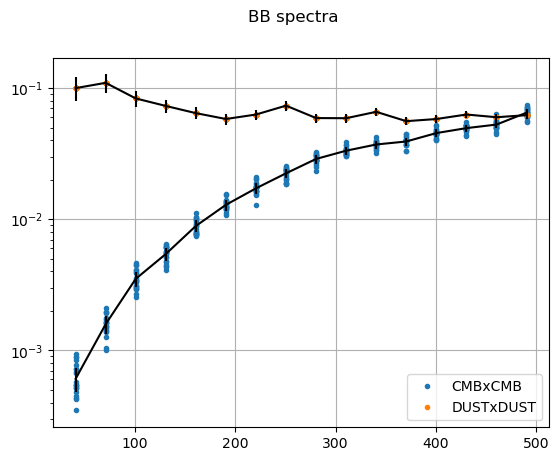

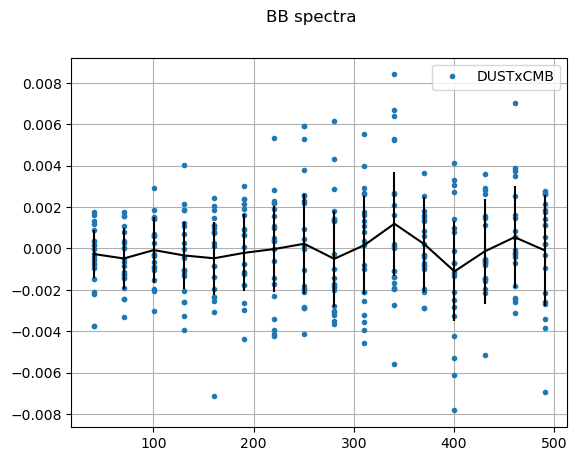

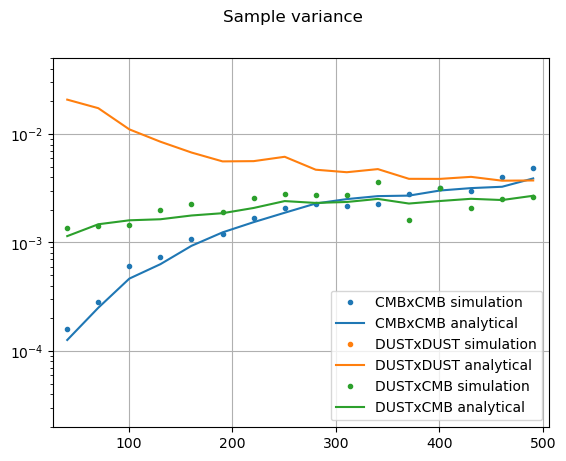

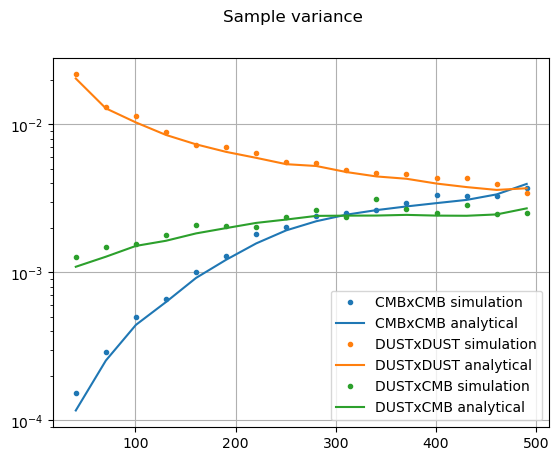

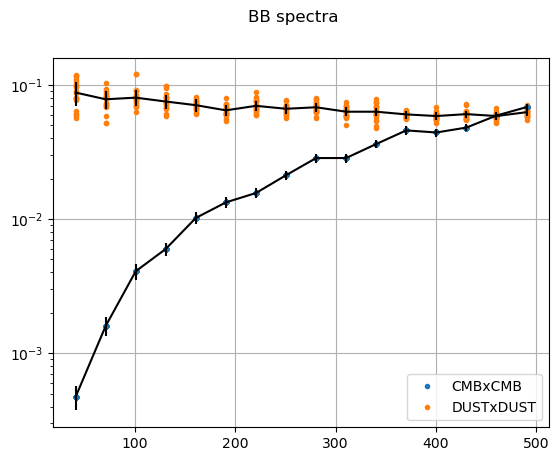

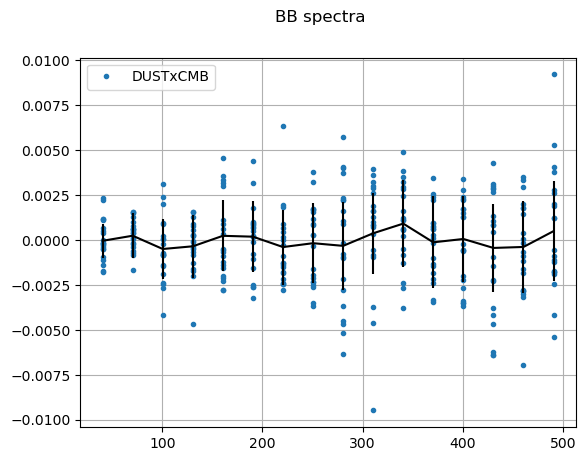

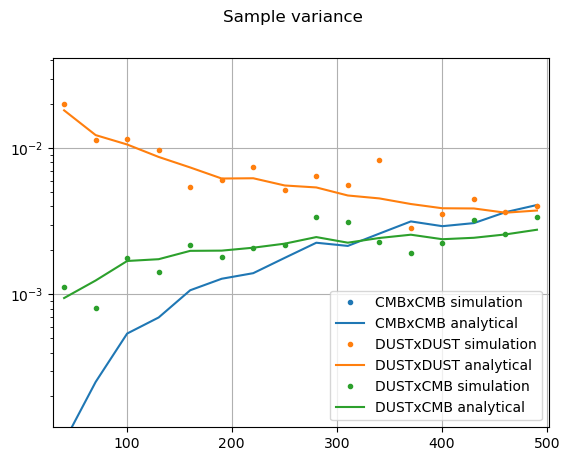

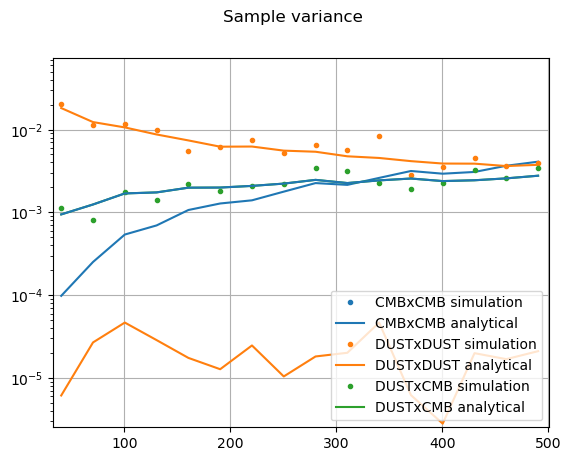

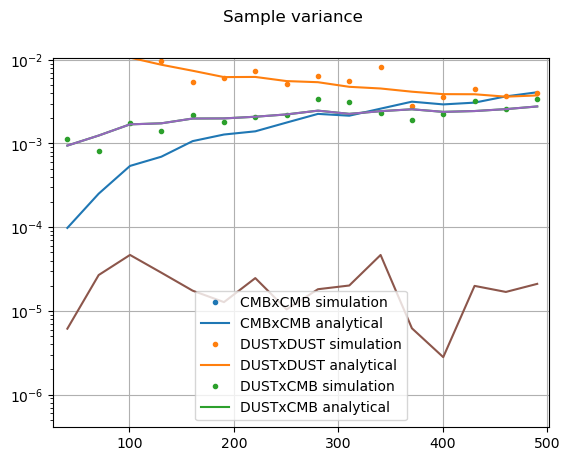

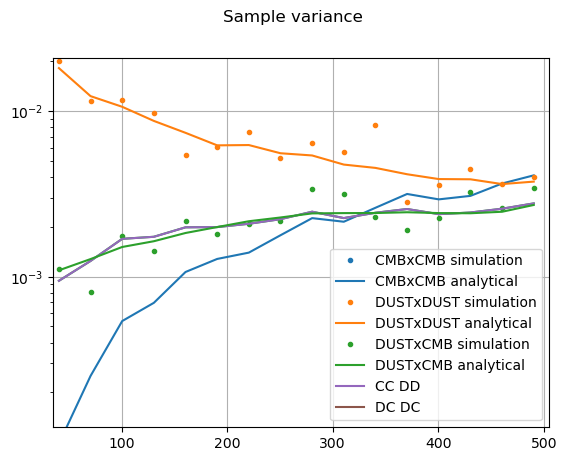

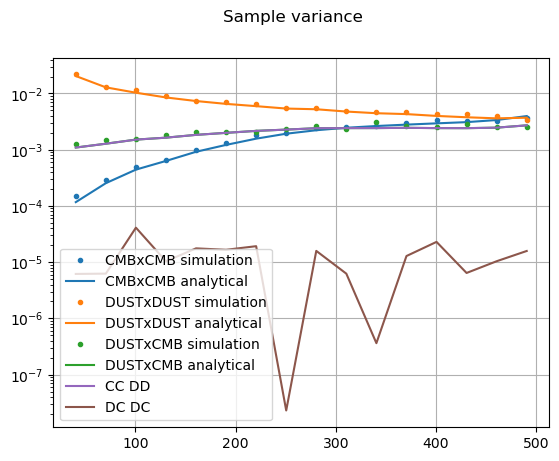

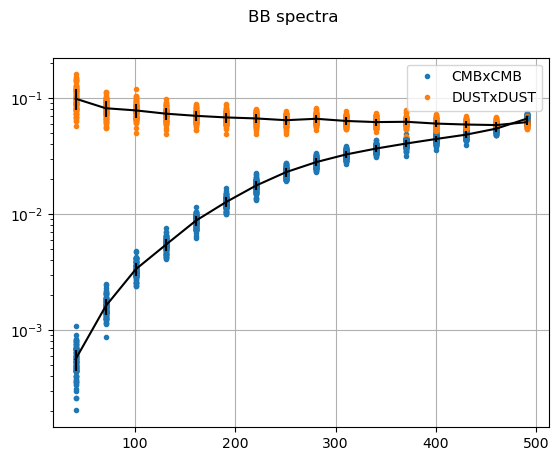

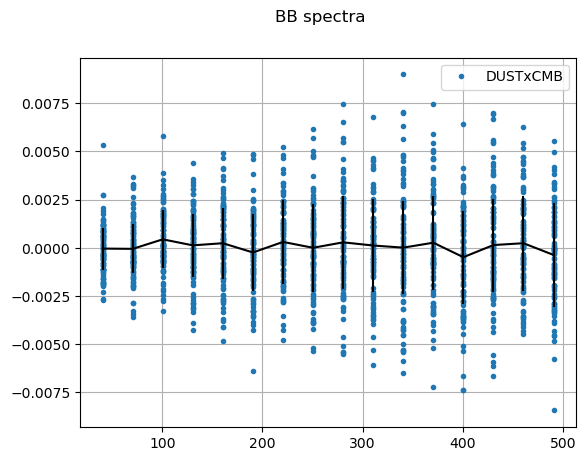

In [36]:
%matplotlib inline

plt.figure()
plt.suptitle('BB spectra')
for i in range(N):
    if i==0:
        plt.plot(ell_nam,DlBB_i[i,0,0],'.',color='C0',label='CMBxCMB')
        plt.plot(ell_nam,DlBB_i[i,1,1],'.',color='C1',label='DUSTxDUST')
    plt.plot(ell_nam,DlBB_i[i,0,0],'.',color='C0')
    plt.plot(ell_nam,DlBB_i[i,1,1],'.',color='C1')
plt.errorbar(ell_nam,np.mean(DlBB_i[:,0,0,:],axis=0),yerr=np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0))**2),color='k')
plt.errorbar(ell_nam,np.mean(DlBB_i[:,1,1,:],axis=0),yerr=np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,1,1,:],axis=0))**2),color='k')
    
plt.yscale('log')
plt.grid()
plt.legend()

plt.figure()
plt.suptitle('BB spectra')
for i in range(N):
    if i==0:
        plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0',label='DUSTxCMB')
    plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0')
plt.errorbar(ell_nam,np.mean(DlBB_i[:,1,0,:],axis=0),yerr=np.sqrt(1/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0)*np.mean(DlBB_i[:,1,1,:],axis=0)+np.mean(DlBB_i[:,1,0,:],axis=0)*np.mean(DlBB_i[:,0,1,:],axis=0))),color='k')
             
# plt.yscale('log')
plt.grid()
plt.legend()

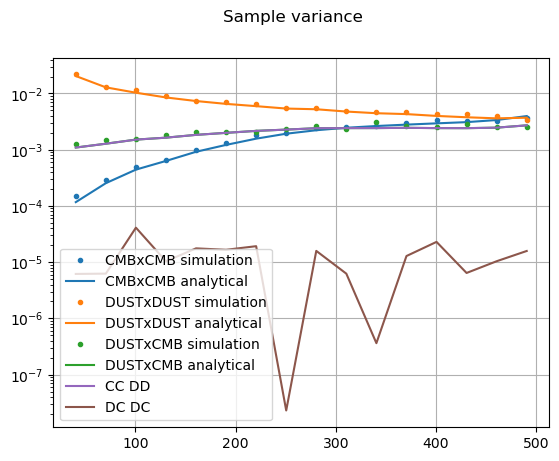

In [37]:
plt.figure()
plt.suptitle('Sample variance')

plt.plot(ell_nam,np.std(DlBB_i[:,0,0,:],axis=0),'.',color='C0',label='CMBxCMB simulation')
plt.plot(ell_nam,np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0))**2),'-',color='C0',label='CMBxCMB analytical')
plt.plot(ell_nam,np.std(DlBB_i[:,1,1,:],axis=0),'.',color='C1',label='DUSTxDUST simulation')
plt.plot(ell_nam,np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,1,1,:],axis=0))**2),'-',color='C1',label='DUSTxDUST analytical')
plt.plot(ell_nam,np.std(DlBB_i[:,1,0,:],axis=0),'.',color='C2',label='DUSTxCMB simulation')
plt.plot(ell_nam,np.sqrt(1/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0)*np.mean(DlBB_i[:,1,1,:],axis=0)+np.mean(DlBB_i[:,1,0,:],axis=0)*np.mean(DlBB_i[:,0,1,:],axis=0))),'-',color='C2',label='DUSTxCMB analytical')
plt.plot(ell_nam,np.sqrt(1/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0)*np.mean(DlBB_i[:,1,1,:],axis=0))),'-',color='C4',label='CC DD')
plt.plot(ell_nam,np.sqrt(1/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,1,0,:],axis=0)*np.mean(DlBB_i[:,0,1,:],axis=0))),'-',color='C5',label='DC DC')
# plt.plot(ell_nam,DlBB_i[i,1,1],'.',color='C1',label='DUSTxDUST')

plt.yscale('log')
plt.grid()
plt.legend()

# plt.figure()
# plt.suptitle('BB spectra')
# for i in range(N):
#     if i==0:
#         plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0',label='DUSTxCMB')
#     plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0')

# # plt.yscale('log')
# plt.grid()
# plt.legend()

In [32]:
# DlBB_i = np.load('DlBBi_100reals_diffdustandcmbseeds.npy')

# plt.figure()
# plt.suptitle('Sample variance')

# plt.plot(ell_nam,np.std(DlBB_i[:,0,0,:],axis=0),'.',color='C0',label='CMBxCMB simulation')
# plt.plot(ell_nam,np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0))**2),'-',color='C0',label='CMBxCMB analytical')
# plt.plot(ell_nam,np.std(DlBB_i[:,1,1,:],axis=0),'.',color='C1',label='DUSTxDUST simulation')
# plt.plot(ell_nam,np.sqrt(2/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,1,1,:],axis=0))**2),'-',color='C1',label='DUSTxDUST analytical')
# plt.plot(ell_nam,np.std(DlBB_i[:,1,0,:],axis=0),'.',color='C2',label='DUSTxCMB simulation')
# plt.plot(ell_nam,np.sqrt(1/(2*ell_nam+1)*1/namaster.fsky*(1/dl)*(np.mean(DlBB_i[:,0,0,:],axis=0)*np.mean(DlBB_i[:,1,1,:],axis=0)+np.mean(DlBB_i[:,1,0,:],axis=0)*np.mean(DlBB_i[:,0,1,:],axis=0))),'-',color='C2',label='DUSTxCMB analytical')
# # plt.plot(ell_nam,DlBB_i[i,1,1],'.',color='C1',label='DUSTxDUST')

# plt.yscale('log')
# plt.grid()
# plt.legend()

# # plt.figure()
# # plt.suptitle('BB spectra')
# # for i in range(N):
# #     if i==0:
# #         plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0',label='DUSTxCMB')
# #     plt.plot(ell_nam,DlBB_i[i,1,0],'.',color='C0')

# # # plt.yscale('log')
# # plt.grid()
# # plt.legend()